# Order Note Analysis - Review and Model

Goal:  convert order note text into traing and testing text source

In [1]:
#%pylab inline
%matplotlib inline
%config InlineBackend.figure_format='retina' 

import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import os, sys
import warnings

warnings.filterwarnings('ignore')

In [2]:
import seaborn as sns
sns.set_context('poster')
sns.set_style('whitegrid') 
# sns.set_style('darkgrid') 
# plt.rcParams['figure.figsize'] = 12, 8  # plotsize 

## Review and Identify working set

In [4]:
df = pd.read_pickle('../data/note_clean4')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595936 entries, 0 to 595935
Data columns (total 5 columns):
index                  595936 non-null int64
salesorder_number      595936 non-null float64
order_date             595936 non-null datetime64[ns]
order_type_category    595936 non-null category
note                   595936 non-null object
dtypes: category(1), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 18.8+ MB


In [11]:
df['yr'] = df['order_date'].dt.year
df['mo'] = df['order_date'].dt.month

In [13]:
df.head()

,index,salesorder_number,order_date,order_type_category,note,yr,mo
0,0,1002465.0,2017-06-01,b'CM',Reason Code: NRSP - No Reason Specified Reques...,2017,6
1,1,1002466.0,2017-06-01,b'CA',Reason Code: DUPL - Duplicate Order Reference ...,2017,6
2,2,1002467.0,2017-06-01,b'CA',Reason Code: WIOD - Wrong Item Ordered What d...,2017,6
3,3,1002468.0,2017-06-01,b'CM',Shkurte Entered By: DFINLA Ref Invoice: 13...,2017,6
4,4,1002469.0,2017-06-01,b'CA',Reason Code: WIOD - Wrong Item Ordered What d...,2017,6


### by type

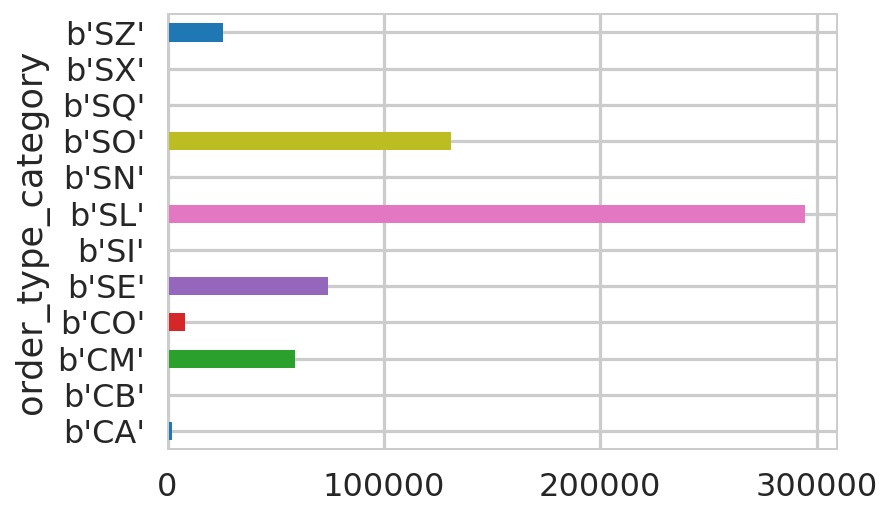

In [14]:
df.groupby('order_type_category')['note'].count().plot(kind='barh')

### by month

interesting:  notes appear to have rolling 12 months

In [15]:
df.groupby(pd.Grouper(key='order_date', freq='M'))['note'].count()

order_date
2017-06-30    50937
2017-07-31    41466
2017-08-31    46089
2017-09-30    46705
2017-10-31    49437
2017-11-30    52824
2017-12-31    41443
2018-01-31    45675
2018-02-28    42665
2018-03-31    49657
2018-04-30    49318
2018-05-31    52031
2018-06-30    27689
Freq: M, Name: note, dtype: int64

### pivot for scope

by year by type

In [16]:
pd.pivot_table(df, values='note', index=['yr'], columns=['order_type_category'], aggfunc='count')

order_type_category,b'CA',b'CB',b'CM',b'CO',b'SE',b'SI',b'SL',b'SN',b'SO',b'SQ',b'SX',b'SZ'
yr,,,,,,,,,,,,
2017,732,12,32932,4675,40034,26,162467,15,74054,26,344,13584
2018,1324,4,26110,3614,34051,13,132265,4,57050,38,352,12210


by month by type

In [17]:
pd.pivot_table(df, values='note', index=['yr','mo'], columns=['order_type_category'], aggfunc='count')

order_type_category  b'CA'  b'CB'   b'CM'  b'CO'   b'SE'  b'SI'    b'SL'  \
yr   mo                                                                    
2017 6               112.0    2.0  5199.0  850.0  5794.0    NaN  26103.0   
     7                65.0    NaN  3921.0  466.0  5003.0    7.0  19377.0   
     8                91.0    NaN  4221.0  812.0  5708.0    4.0  22917.0   
     9                92.0    4.0  4688.0  612.0  5531.0    3.0  23299.0   
     10              128.0    3.0  4937.0  656.0  6381.0    3.0  24127.0   
     11              131.0    3.0  5638.0  693.0  6723.0    8.0  25762.0   
     12              113.0    NaN  4328.0  586.0  4894.0    1.0  20882.0   
2018 1               131.0    NaN  4566.0  603.0  6143.0    3.0  21574.0   
     2               117.0    NaN  4337.0  569.0  4892.0    1.0  21815.0   
     3               120.0    1.0  4516.0  711.0  6283.0    5.0  25219.0   
     4               136.0    3.0  5402.0  594.0  5828.0    4.0  24681.0   
     5               144.0    NaN  5171.0  701.0  7113.0    NaN  25223.0   
     6               676.0    NaN  2118.0  436.0  3792.0    NaN  13753.0   

order_type_category  b'SN'    b'SO'  b'SQ'  b'SX'   b'SZ'  
yr   mo                                                    
2017 6                 1.0  11015.0    3.0   60.0  1798.0  
     7                 1.0  10675.0    3.0   36.0  1912.0  
     8                 2.0  10321.0    4.0   32.0  1977.0  
     9                 2.0  10537.0    6.0   47.0  1884.0  
     10                4.0  11043.0    7.0   48.0  2100.0  
     11                3.0  11603.0    1.0   61.0  2198.0  
     12                2.0   8860.0    2.0   60.0  1715.0  
2018 1                 NaN  10305.0    2.0   62.0  2286.0  
     2                 2.0   9049.0    3.0   67.0  1813.0  
     3                 NaN  10571.0    9.0   74.0  2148.0  
     4                 NaN  10326.0    5.0   57.0  2282.0  
     5                 2.0  11182.0   17.0   66.0  2412.0  
     6                 NaN   5617.0    2.0   26.0  1269.0

### Create working set

scope:  June 2017 to Jun 2018; CM, CO, SE, SL, SO, SX, SZ

In [18]:
df.index = df.order_date

In [19]:
df.index

DatetimeIndex(['2017-06-01', '2017-06-01', '2017-06-01', '2017-06-01',
               '2017-06-01', '2017-06-01', '2017-06-01', '2017-06-01',
               '2017-06-01', '2017-06-01',
               ...
               '2018-06-15', '2018-06-15', '2018-06-15', '2018-06-15',
               '2018-06-15', '2018-06-15', '2018-06-15', '2018-06-15',
               '2018-06-15', '2018-06-15'],
              dtype='datetime64[ns]', name='order_date', length=595936, freq=None)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 595936 entries, 2017-06-01 to 2018-06-15
Data columns (total 7 columns):
index                  595936 non-null int64
salesorder_number      595936 non-null float64
order_date             595936 non-null datetime64[ns]
order_type_category    595936 non-null category
note                   595936 non-null object
yr                     595936 non-null int64
mo                     595936 non-null int64
dtypes: category(1), datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 32.4+ MB


In [13]:
df.loc[df.order_date == '2018-02-14',[ 'salesorder_number', 'id', 'note', 'order_type', 'chksum']]

,salesorder_number,id,note,order_type,chksum
order_date,,,,,
2018-02-14,11088929.0,1172799,11088929,b'SZ',b'\xdd\xd91`\x93\xaa\x1e\xa18\x8e\xde\xe0\x03\...
2018-02-14,11088930.0,1172800,Customer PO--- A0000223674 ATTN: Cindy Lalonde...,b'SZ',"b'\\,\xfa\x86\x8b\xfa%\xc0\xc6\xb2p\xc2\xfa\x9..."
2018-02-14,11088930.0,1172801,****Prices verified in coupa***,b'SZ',b'\xa1\xd3\xf3\xd0\x08cV\x98u\xa3\xca-\xdf\xb2...
2018-02-14,11088931.0,1172802,Customer PO--- A0000223666 ATTN: Cindy Lalonde...,b'SZ',"b'\xa5\x01\xe9\x7f*\xc3mf=]W""\x95-\xaf\xc7\x83..."
2018-02-14,11088931.0,1172803,***Prices verified in Coupa***,b'SZ',b'#9C\x89m?\xa4\xd8\xff\xc72\\\x15\xf38P\xfb\x...
2018-02-14,11088932.0,1172804,Customer PO--- A0000223663 ATTN: Nicole Van De...,b'SZ',b'$JI\xe1H\xa7\x018\xc5\x11\xfc\xa3T$\xcar\xa6...
2018-02-14,11088933.0,1172805,Customer PO--- A0000223464 ATTN: Emily Ward Fe...,b'SZ',b'6\x1dY\x14\x16\xfc\xcbK\x10\xa5\x0b`\xfa\xb6...
2018-02-14,11088933.0,1172806,***Prices verified in coupa**8,b'SZ',b'\x8f\xc7\x85\x88\xbc\x81AU\xcd>$\x8e\x1dd\x9...
2018-02-14,11088934.0,1172807,"Records room 4 way syringe leaking water, repl...",b'SL',b'j\x08\xcdUr\xdc\x1e\xf0\xc3\x8ce\xad.\xfe\xd...


In [22]:
df2 = df['2017-06-01':'2018-06-30'][['salesorder_number', 'id', 'note', 'order_type_category', 'chksum']]

KeyError: "['id' 'chksum'] not in index"

In [24]:
df2['order_type_category'] = df2['order_type'].astype('category')

NameError: name 'df2' is not defined

In [8]:
df2.drop('order_type', axis=1, inplace=True)

In [23]:
df2.describe()

NameError: name 'df2' is not defined

In [10]:
df3 = df2.drop_duplicates(subset=['salesorder_number', 'chksum'], keep='first', inplace=False)

In [11]:
df3.drop('chksum', axis=1, inplace=True)

In [12]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1642323 entries, 2018-02-14 to 2018-06-15
Data columns (total 4 columns):
salesorder_number      1642323 non-null float64
id                     1642323 non-null int64
note                   1642323 non-null object
order_type_category    1642323 non-null category
dtypes: category(1), float64(1), int64(1), object(1)
memory usage: 51.7+ MB


In [13]:
df3.head()

,salesorder_number,id,note,order_type_category
order_date,,,,
2018-02-14,11088929.0,1172799,11088929,b'SZ'
2018-02-14,11088930.0,1172800,Customer PO--- A0000223674 ATTN: Cindy Lalonde...,b'SZ'
2018-02-14,11088930.0,1172801,****Prices verified in coupa***,b'SZ'
2018-02-14,11088931.0,1172802,Customer PO--- A0000223666 ATTN: Cindy Lalonde...,b'SZ'
2018-02-14,11088931.0,1172803,***Prices verified in Coupa***,b'SZ'


In [33]:
df3.groupby('salesorder_number')['id'].count().sort_values(ascending=False)

salesorder_number
11304004.0    104
10525372.0     95
11168230.0     91
11134279.0     91
11282043.0     90
10968267.0     86
11003598.0     86
11132951.0     85
10969669.0     80
10601080.0     79
10947488.0     75
10719604.0     74
10542974.0     74
11130107.0     73
10668092.0     72
10975009.0     71
10977187.0     71
10650730.0     71
10724698.0     70
10969372.0     69
11376382.0     67
10593659.0     66
10735617.0     66
11136482.0     66
10822142.0     66
10782812.0     65
10905879.0     65
10460470.0     64
10787472.0     64
10806064.0     64
             ... 
10898126.0      1
10898127.0      1
10898132.0      1
10898139.0      1
10898140.0      1
10898146.0      1
10898152.0      1
10898153.0      1
10898066.0      1
10898065.0      1
10898059.0      1
10898042.0      1
10897941.0      1
10897951.0      1
10897953.0      1
10897954.0      1
10897961.0      1
10897966.0      1
10897991.0      1
10897993.0      1
10898001.0      1
10898003.0      1
10898010.0      1
10898016.0

In [59]:
pd.Series(range(1,100))

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
12    13
13    14
14    15
15    16
16    17
17    18
18    19
19    20
20    21
21    22
22    23
23    24
24    25
25    26
26    27
27    28
28    29
29    30
      ..
69    70
70    71
71    72
72    73
73    74
74    75
75    76
76    77
77    78
78    79
79    80
80    81
81    82
82    83
83    84
84    85
85    86
86    87
87    88
88    89
89    90
90    91
91    92
92    93
93    94
94    95
95    96
96    97
97    98
98    99
Length: 99, dtype: int64

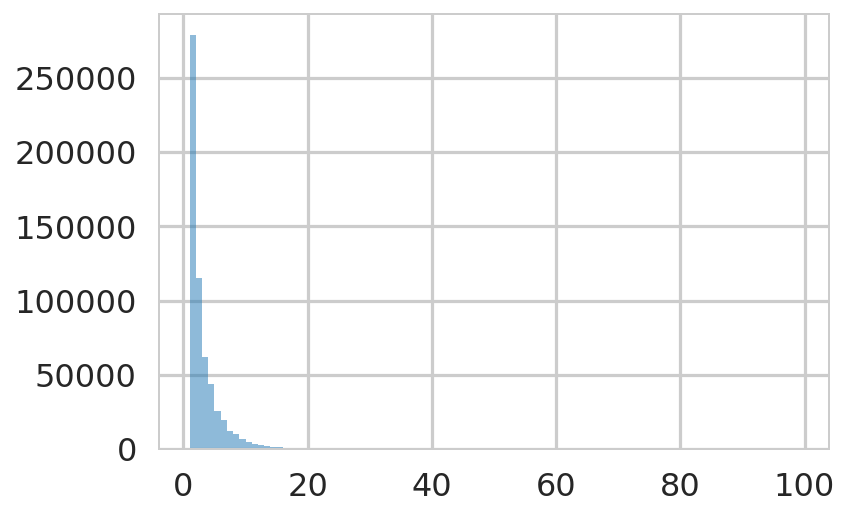

In [60]:
df3.groupby('salesorder_number')['id'].count().hist(alpha=0.5, bins=pd.Series(range(1,100)))

In [14]:
df4 = df3[df3['salesorder_number']==11282043.0]

In [28]:
df4

,salesorder_number,id,note,order_type_category
order_date,,,,
2018-04-26,11282043.0,1503682,Customer PO: C00038512,b'SL'
2018-04-26,11282043.0,1503683,Bill at $140 with NO arrival fee. Pricing as per,b'SL'
2018-04-26,11282043.0,1503684,contract,b'SL'
2018-04-26,11282043.0,1503685,"April 16, 2018",b'SL'
2018-04-26,11282043.0,1503686,Tag# 488,b'SL'
2018-04-26,11282043.0,1503687,"Dental cart with cut tubing, syringe tip crack...",b'SL'
2018-04-26,11282043.0,1503688,jar holders loose,b'SL'
2018-04-26,11282043.0,1503689,"-replace syringe tip nut, replace slow speed 4",b'SL'
2018-04-26,11282043.0,1503690,hole tubing and straighten/tighten all jar hol...,b'SL'


In [17]:
df3.to_pickle('../data/note_clean2')

In [113]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1642323 entries, 2018-02-14 to 2018-06-15
Data columns (total 4 columns):
salesorder_number      1642323 non-null float64
id                     1642323 non-null int64
note                   1642323 non-null object
order_type_category    1642323 non-null category
dtypes: category(1), float64(1), int64(1), object(1)
memory usage: 91.7+ MB


In [53]:
dfs = df3.index.unique()

In [89]:
df5 = 'None'

In [90]:
if df5  :
    print ('exits') 
else:
        print ('no')

exits


In [98]:
s = 'test'
s + str(1)

'test1'

In [99]:

for i in dfs.to_period(freq='M').unique() :
    print (i)
    df_temp = df3[df3.index.to_period(freq='M') == i].pivot_table(index=['salesorder_number', 'order_date', 'order_type_category'],                               
                                     values='note',
                                     aggfunc=lambda x: ' '.join(x))
    df_temp.to_pickle('../data/note_clean3_' + str(i))
    

2018-02
2018-05
2018-06
2017-06
2018-03
2017-07
2017-08
2017-09
2018-04
2017-10
2017-11
2017-12
2018-01


In [144]:
files = [
    "../data/note_clean3_2017-06",
"../data/note_clean3_2017-07",
"../data/note_clean3_2017-08",
"../data/note_clean3_2017-09",
"../data/note_clean3_2017-10",
"../data/note_clean3_2017-11",
"../data/note_clean3_2017-12",
"../data/note_clean3_2018-01",
"../data/note_clean3_2018-02",
"../data/note_clean3_2018-03",
"../data/note_clean3_2018-04",
"../data/note_clean3_2018-05",
"../data/note_clean3_2018-06"]

df = pd.concat(map(pd.read_pickle, files))



In [52]:
df.head()

,,,note
salesorder_number,order_date,order_type_category,
1002465.0,2017-06-01,b'CM',reason code nrsp no reason specified requested...
1002466.0,2017-06-01,b'CA',reason code dupl duplicate order reference pre...
1002467.0,2017-06-01,b'CA',reason code wiod wrong item ordered what did t...
1002468.0,2017-06-01,b'CM',shkurte entered by dfinla ref invoice 13163577...
1002469.0,2017-06-01,b'CA',reason code wiod wrong item ordered what did t...


In [7]:
df.to_pickle('../data/note_clean4')

## Create model

In [3]:
df = pd.read_pickle('../data/note_clean4')

In [4]:
#df.reset_index(inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595936 entries, 0 to 595935
Data columns (total 5 columns):
index                  595936 non-null int64
salesorder_number      595936 non-null float64
order_date             595936 non-null datetime64[ns]
order_type_category    595936 non-null category
note                   595936 non-null object
dtypes: category(1), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 18.8+ MB


## bag of words

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
import re
import nltk

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [9]:
def preproc (text) :
    text = re.sub('[\W]+', ' ', text.lower())
    return text

In [10]:
df['note'] = df['note'].apply(preproc)

In [11]:
def tokenizer(text) :
    return text.split()

In [12]:
df['note'].head().apply(tokenizer)

0    [reason, code, nrsp, no, reason, specified, re...
1    [reason, code, dupl, duplicate, order, referen...
2    [reason, code, wiod, wrong, item, ordered, wha...
3    [shkurte, entered, by, dfinla, ref, invoice, 1...
4    [reason, code, wiod, wrong, item, ordered, wha...
Name: note, dtype: object

In [13]:
count = CountVectorizer()

In [14]:
docs = df['note'].values

In [15]:
count

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [16]:
bag = count.fit_transform(docs)

In [17]:
count.vocabulary_

{'reason': 243302,
 'code': 197435,
 'nrsp': 232913,
 'no': 232458,
 'specified': 254466,
 'requested': 245313,
 'by': 193076,
 'comments': 197867,
 'carole': 194556,
 'bisson': 191061,
 'notl': 232732,
 'ext': 208962,
 '3021': 125952,
 'jun': 221677,
 '17': 116054,
 'katharine': 222097,
 '3143': 126578,
 'entered': 207468,
 'cbisso': 195105,
 'reference': 244038,
 'invoice': 219655,
 '13155800': 57379,
 'dupl': 205082,
 'duplicate': 205088,
 'order': 235313,
 'previous': 240477,
 '13112063': 56598,
 'this': 258522,
 'should': 252746,
 'only': 234617,
 'have': 216261,
 'been': 190376,
 'free': 211909,
 'goods': 214346,
 'as': 187350,
 'per': 237754,
 'back': 189122,
 'pocket': 239350,
 'deal': 201535,
 'with': 265258,
 'eric': 207841,
 'wilson': 265118,
 'instructions': 219046,
 'were': 264828,
 'unclear': 261213,
 'cindy': 196572,
 'x5200': 288579,
 'hfx': 216723,
 'nov': 232793,
 '13': 55285,
 '2017': 119838,
 'nadine': 231338,
 '3027': 125968,
 'cull': 200137,
 'cbilbr': 195103,
 'r

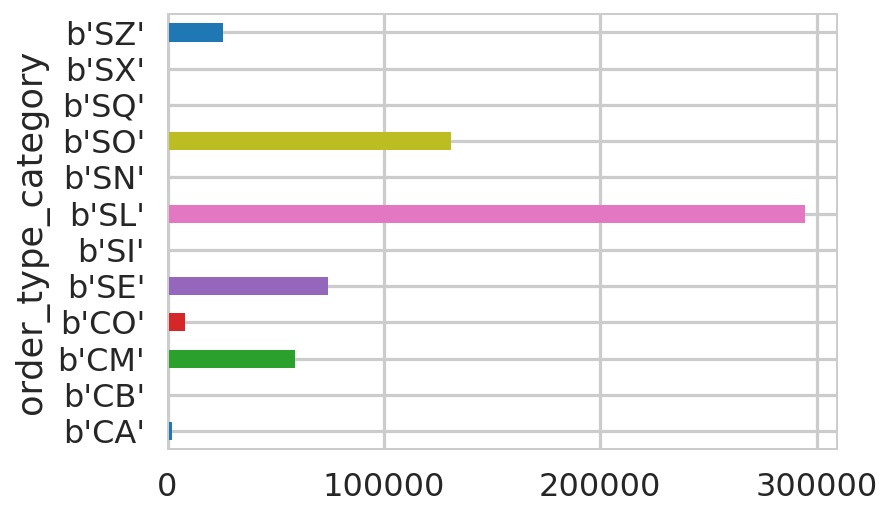

In [18]:
df.groupby('order_type_category')['note'].count().plot(kind='barh')